In [12]:
PATH = 'data/samples/preview/11.12.2022_12.45.00-11.12.2022_12.46.00'

In [2]:
import json


def read_points(path: str) -> dict:
    with open(path, 'r') as f:
        file_json = json.load(f)
    return file_json['shapes']

In [97]:
import os
import cv2
import numpy as np
from tqdm import tqdm

COLORS = [
    (1, 1, 1),
    (2, 2, 2),
    (3, 3, 3),
    (4, 4, 4),
    (5, 5, 5),
    (6, 6, 6),
    (7, 7, 7)
]

CLASSES = {
    'column': (0, COLORS[0]),
    'fence': (1, COLORS[1]),
    'road': (2, COLORS[2]),
    'curb': (3, COLORS[3]),
    'hatch': (4, COLORS[4]),
    'traffic_light': (5, COLORS[5]),
    'traffic_lights': (5, COLORS[5]),
    'car': (6, COLORS[6])
}


def draw_masks(img_path: str, anno_path: str, file_name: str):
    img = cv2.imread(os.path.join(img_path, f'{file_name}.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    points = read_points(os.path.join(anno_path, f'{file_name}.json'))
    masks = np.zeros_like(img)
    for figure in points:
        cntrs = np.array(figure['points'], dtype=np.int32)
        cntrs = cntrs.reshape((-1, *cntrs.shape))
        masks = cv2.drawContours(masks, cntrs, -1, CLASSES[figure['label']][1], thickness=cv2.FILLED)

    masks[masks == 7] = 0
    return masks, img

In [98]:
DATA_PATH = 'C:\\MySpace\\datasets'
os.mkdir(os.path.join(DATA_PATH, 'road_masks', 'masks'))
os.mkdir(os.path.join(DATA_PATH, 'road_masks', 'imgs'))
annos = os.listdir(os.path.join(DATA_PATH, 'roads', 'tlc_annos_num'))

for anno in tqdm(annos):
    anno_file = anno[:-5]
    mask, img = draw_masks(img_path=os.path.join(DATA_PATH, 'roads', 'tl_nums'),
                           anno_path=os.path.join(DATA_PATH, 'roads', 'tlc_annos_num'),
                           file_name=anno_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(DATA_PATH, 'road_masks', 'masks', f'{anno_file}_mask.png'), mask)
    cv2.imwrite(os.path.join(DATA_PATH, 'road_masks', 'imgs', f'{anno_file}_img.png'), img)


100%|██████████| 201/201 [00:12<00:00, 16.57it/s]


In [147]:
from tqdm import tqdm

MAX_PIC = 170
SHAPE = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('C:\MySpace\Projects\Roads\data\samples\preview\output.avi', fourcc, 30.0, SHAPE)

for i in tqdm(range(171)):
    i_len = len(str(i))
    file_name = f"{'0' * (8 - i_len)}{i}"
    pos_line = 1920 // 150 * i
    img = draw_masks(file_name, pos_line).permute((1, 2, 0)).detach().numpy()
    img = cv2.line(img, pt1=(pos_line, 0), pt2=(pos_line, 1080), color=((25, 25, 190)), thickness=2)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    out.write(img)

out.release()

100%|██████████| 171/171 [00:14<00:00, 11.58it/s]


In [2]:
from tqdm import tqdm
import os
import cv2

PATH = 'C:\\MySpace\\datasets\\roads'

OLD_FOLDER = 'winter_df_part2'
NEW_FOLDER = 'fence_columns'

folders = os.listdir(os.path.join(PATH, OLD_FOLDER))


def get_random_frame(video_path: str):
    rand_cap = cv2.VideoCapture(video_path)
    if not rand_cap.isOpened():
        return None
    total_frames = rand_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    rand_cap.set(cv2.CAP_PROP_POS_FRAMES, random.randint(a=0, b=total_frames - 1))
    rand_ret, rand_image = rand_cap.read()
    if not rand_ret:
        return None
    else:
        return rand_image


frame_count = 2944
for folder in tqdm(folders):
    videos = os.listdir(os.path.join(PATH, OLD_FOLDER, folder))
    for video in videos:
        frame = get_random_frame(os.path.join(PATH, OLD_FOLDER, folder, video))
        if frame is None:
            continue

        cv2.imwrite(os.path.join(PATH, NEW_FOLDER, f'{frame_count}.jpg'), frame)
        frame_count += 1

100%|██████████| 129/129 [04:12<00:00,  1.96s/it]


In [17]:
import shutil
import random
from tqdm import tqdm

new_dataset_path = os.path.join('C:\\MySpace\\datasets', 'road_masks')

img_dir = os.path.join(new_dataset_path, 'img_dir')
ann_dir = os.path.join(new_dataset_path, 'ann_dir')
os.mkdir(img_dir)
os.mkdir(ann_dir)

new_dataset_train_path_img = os.path.join(img_dir, 'train')
new_dataset_test_path_img = os.path.join(img_dir, 'test')
new_dataset_val_path_img = os.path.join(img_dir, 'val')
os.mkdir(new_dataset_train_path_img)
os.mkdir(new_dataset_test_path_img)
os.mkdir(new_dataset_val_path_img)

new_dataset_train_path_ann = os.path.join(ann_dir, 'train')
new_dataset_test_path_ann = os.path.join(ann_dir, 'test')
new_dataset_val_path_ann = os.path.join(ann_dir, 'val')
os.mkdir(new_dataset_train_path_ann)
os.mkdir(new_dataset_test_path_ann)
os.mkdir(new_dataset_val_path_ann)

annos = os.listdir(ann_dir)

for anno in tqdm(annos):
    anno_path = os.path.join(ann_dir, anno)
    img_name = anno.replace('mask', 'img')
    img_path = os.path.join(img_dir, img_name)
    prob = random.randint(1, 10)
    if prob == 10:
        shutil.copyfile(img_path, os.path.join(new_dataset_val_path_img, img_name))
        shutil.copyfile(anno_path, os.path.join(new_dataset_val_path_ann, anno))

    if prob == 9:
        shutil.copyfile(img_path, os.path.join(new_dataset_test_path_img, img_name))
        shutil.copyfile(anno_path, os.path.join(new_dataset_test_path_ann, anno))

    else:
        shutil.copyfile(img_path, os.path.join(new_dataset_train_path_img, img_name))
        shutil.copyfile(anno_path, os.path.join(new_dataset_train_path_ann, anno))

  0%|          | 0/3 [00:00<?, ?it/s]


PermissionError: [Errno 13] Permission denied: 'C:\\MySpace\\datasets\\road_masks\\img_dir\\test'

In [91]:



def rename(img_path, annos_path,
           new_img_path, new_annos_path):
    files = os.listdir(annos_path)
    count = 3424
    for file in files:
        img_name = file.replace('.json', '.jpg')
        shutil.copy(
            os.path.join(img_path, img_name),
            os.path.join(new_img_path, f'{count}.jpg')
        )
        shutil.copy(
            os.path.join(annos_path, file),
            os.path.join(new_annos_path, f'{count}.json')
        )
        count += 1


rename(
    img_path='C:\\MySpace\\datasets\\roads\\traffic_lights',
    annos_path='C:\\MySpace\\datasets\\roads\\tlc_anno',
    new_img_path='C:\\MySpace\\datasets\\roads\\tl_nums',
    new_annos_path='C:\\MySpace\\datasets\\roads\\tlc_annos_num'
)

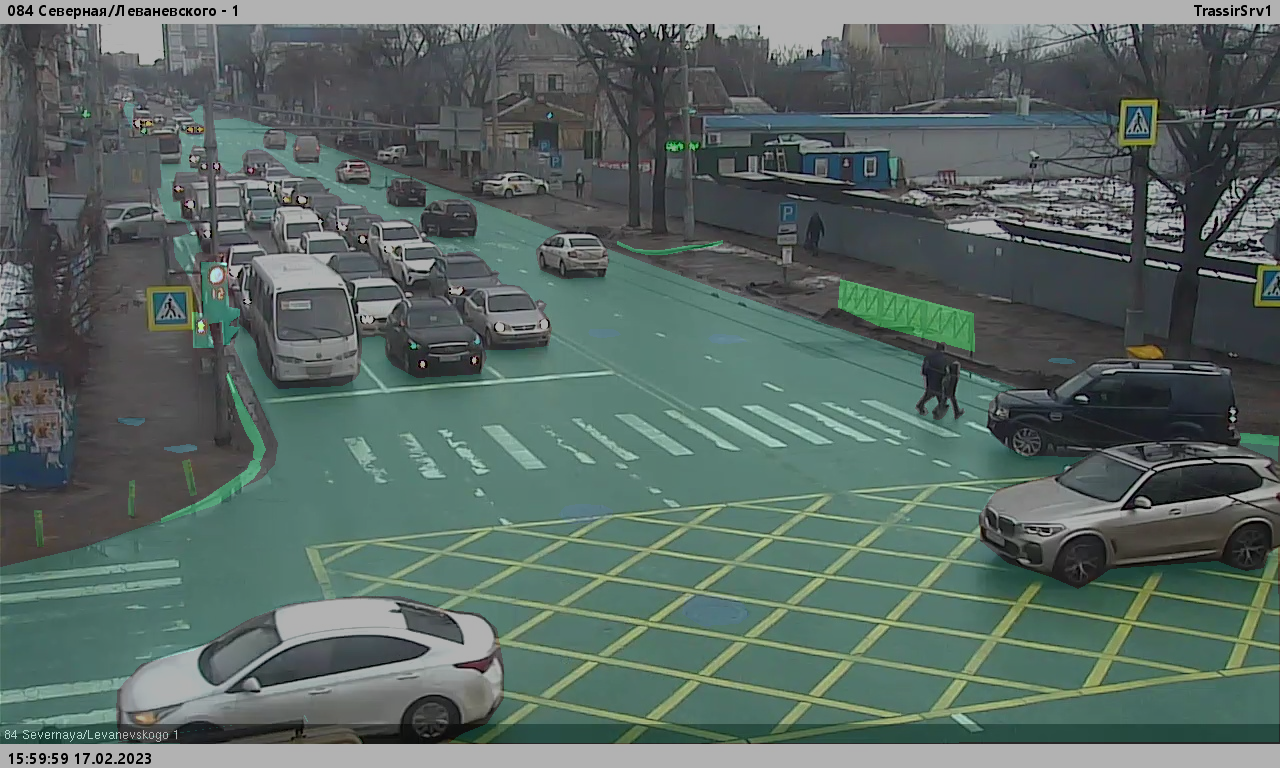

In [90]:
from PIL import Image
import torch
from torchvision.utils import draw_segmentation_masks

img_path = 'C:\\MySpace\\datasets\\roads\\tl_nums'
anno_path = 'C:\\MySpace\\datasets\\roads\\tlc_annos_num'

filename = '160'

anno, img = draw_masks(img_path=img_path,
                       anno_path=anno_path,
                       file_name=filename)

anno = anno[:, :, 0]
mask = torch.zeros((8, *anno.shape))
anno[anno == 7] = 0
for i in np.unique(anno):
    mask[i, anno == i] = 1

mask = mask.to(torch.bool)
img = torch.tensor(img).permute(2, 0, 1)
segm_image = draw_segmentation_masks(img, mask, alpha=0.3)
segm_image = segm_image.permute(1, 2, 0).numpy()
Image.fromarray(segm_image)

In [4]:
import os
import shutil


def convert(path_to_annos: str,
            new_anno_path: str,
            imgs_path: str,
            new_imgs_path: str):
    annos = os.listdir(path_to_annos)
    count = 0
    for anno in tqdm(annos):
        anno_path = os.path.join(path_to_annos, anno)
        points = read_points(anno_path)
        if len(points) == 0:
            continue

        new_img_path = os.path.join(new_imgs_path, f'{count}.jpg')
        shutil.copy(
            os.path.join(imgs_path, anno.replace('.json', '.jpg')),
            new_img_path
        )

        image_ = cv2.imread(new_img_path)
        im_height, im_width = image_.shape[:2]

        file_info = ''
        for info_object in points:
            points_object = info_object['points']
            x1, y1 = float(points_object[0][0]), float(points_object[0][1])
            x2, y2 = float(points_object[1][0]), float(points_object[1][1])

            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            width, height = x2 - x1, y2 - y1
            x, y = (x2 + x1) / 2, (y2 + y1) / 2
            file_info += f'0 {x / im_width} {y / im_height} {width / im_width} {height / im_height}\n'

        with open(os.path.join(new_anno_path, f'{count}.txt'), 'w') as anno_file:
            anno_file.write(file_info)

        count += 1


convert(
    'C:\\MySpace\\datasets\\roads\\traffic_lights_annos',
    'C:\\MySpace\\datasets\\roads\\traffic_lights_yolo\\train\\labels',
    'C:\\MySpace\\datasets\\roads\\traffic_lights',
    'C:\\MySpace\\datasets\\roads\\traffic_lights_yolo\\train\\images',
)

100%|██████████| 973/973 [00:12<00:00, 76.46it/s] 


In [15]:
file_name = 378
anno_test = f'C:\\MySpace\\datasets\\roads\\traffic_lights_yolo\\train\\labels\\{file_name}.txt'

with open(anno_test, 'r') as rf:
    points = []
    for line in rf.readlines():
        line = line.replace('\n', '')
        points.append([float(point) for point in line.split(' ')[1:]])
        points[-1][0] = points[-1][0] - points[-1][2] / 2
        points[-1][1] = points[-1][1] - points[-1][3] / 2
        points[-1][2] = points[-1][2] + points[-1][0]
        points[-1][3] = points[-1][3] + points[-1][1]
points

[[0.03200483091787437,
  0.2798409822866344,
  0.06634963768115941,
  0.3924365942028985],
 [0.01011473429951689,
  0.290534420289855,
  0.028230676328502395,
  0.3842592592592592],
 [0.7151352611940297,
  0.2732690713101162,
  0.7357353855721391,
  0.34452736318407967]]

In [16]:
import cv2
import numpy as np

image = cv2.imread(f'C:\\MySpace\\datasets\\roads\\traffic_lights_yolo\\train\\images\\{file_name}.jpg')

image_rect = image.copy()
points = np.array(points)
points[:, [0, 2]] = points[:, [0, 2]] * image.shape[1]
points[:, [1, 3]] = points[:, [1, 3]] * image.shape[0]
points = points.astype(int)

for rect in points:
    image_rect = cv2.rectangle(image_rect, rect[:2], rect[2:], color=(0, 0, 255))


In [17]:
points

array([[ 40, 214,  84, 301],
       [ 12, 223,  36, 295],
       [915, 209, 941, 264]])

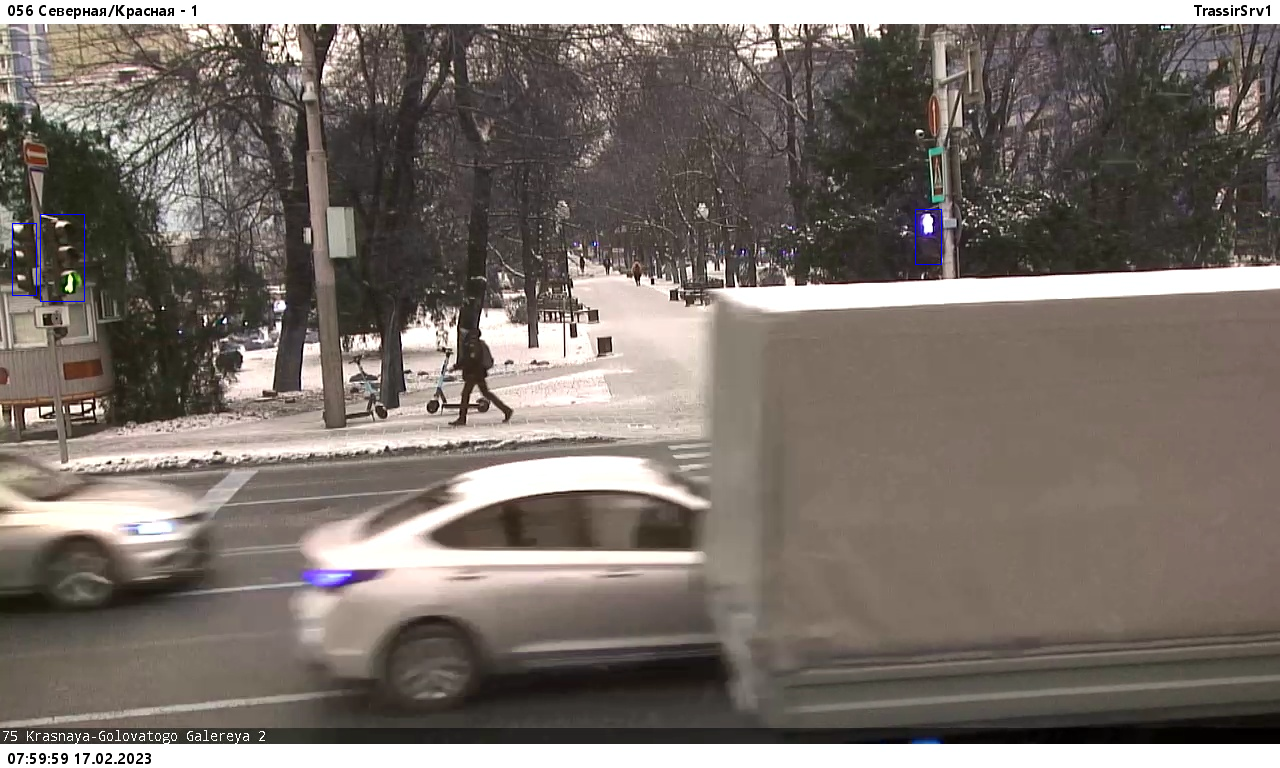

In [18]:
from PIL import Image

Image.fromarray(image_rect)

In [3]:
from yolo.color_detect import split_areas, softmax_colors, get_current_color, put_crops_to_image

from yolo.color_detect import get_rotated

from yolo.color_detect import get_detect_area

from yolo.color_detect import get_colors


def draw_tls(frame, coords, sootn: list):
    frame = np.array(frame)
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    boxes = split_areas(coords, sootn, [2, 1])

    rot_areas = get_rotated(hsv_image, boxes)
    areas = get_detect_area(hsv_image, boxes)
    colors = get_colors(areas)
    colors = softmax_colors(colors, np.array([[False, False, True, True],
                                              [False, False, False, False],
                                              [True, True, False, True],
                                              [False, False, False, False],
                                              [True, False, False, True],
                                              [True, False, False, True],
                                              [True, False, True, True],
                                              [True, False, True, True]]))
    areas = get_current_color(rot_areas, colors)
    areas = put_crops_to_image(frame, areas, sootn, [2, 1], coords)

    return areas

In [4]:

import torch
from torchvision.utils import draw_segmentation_masks
from tqdm import tqdm
from mmcv.utils import config
from mmseg.apis import init_segmentor, inference_segmentor
import cv2
import numpy as np

coords = list()
with open('yolo/conf.txt', 'r') as conf_file:
    for line in conf_file.readlines():
        coords.append([int(value.strip()) for value in line.split(' ')])
sootn = [3, 2]

cfg = 'mmdetection_flow/config.py'
ckpt = "mmdetection_flow/checpoints/iter_50000.pth"

cfg = config.Config.fromfile(cfg)

model = init_segmentor(cfg, ckpt, 'cuda')

SHAPE = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
cap = cv2.VideoCapture('yolo/11.12.2022_15.35.00-11.12.2022_15.36.00.avi')
writer = cv2.VideoWriter('output_masks6.avi', fourcc, 30.0, SHAPE)

cap.set(cv2.CAP_PROP_POS_MSEC, 10_000)

frames_count = 300
if cap.isOpened():
    for i in tqdm(range(frames_count)):
        ret, frame = cap.read()
        if not ret:
            break

        i_len = len(str(i))
        pos_line = SHAPE[0] // frames_count * i + 1
        img = np.array(frame)
        img = img[:, :, :3]
        img = draw_tls(img, coords, sootn)
        out = inference_segmentor(model, img)[0]

        out = torch.from_numpy(out)
        image = torch.tensor(img, dtype=torch.uint8).permute((2, 0, 1))

        mask = torch.zeros((6, *out.size()))
        for i in out.unique().tolist():
            mask[i, out == i] = 1
        mask = mask.to(dtype=bool)
        mask[:, :, :pos_line] = False

        segm_image = draw_segmentation_masks(image, mask, alpha=0.3, colors=[(75, 0, 0), (0, 75, 0),
                                                                             (0, 0, 255), (255, 0, 0),
                                                                             (255, 0, 255), (255, 0, 0), ])

        segm_image = segm_image.permute((1, 2, 0))
        segm_image = segm_image.numpy()
        segm_image = cv2.cvtColor(segm_image, cv2.COLOR_RGB2BGR)

        img = cv2.line(segm_image, pt1=(pos_line, 0), pt2=(pos_line, 1080), color=(25, 25, 190), thickness=2)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('show', img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        writer.write(img)

cap.release()
cv2.destroyAllWindows()
writer.release()

C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: mmdetection_flow/checpoints/iter_50000.pth


 28%|██▊       | 85/300 [00:32<01:22,  2.61it/s]
